# Learning With Errors (LWE)

## import libs

In [1]:
#!conda install pycrypto

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import math
import itertools
import random
from Crypto.Util import number

import matplotlib.pyplot as plt
from matplotlib import collections as matcoll

## Set vector s (secret)

Choose $s \in \mathbb{Z}^m_p$ with arbitrary $m \in \mathbb{N}$

In [3]:
#s = np.array([2, 3]) 
#s = np.array([10, 13, 9]) 
#s = np.array([10, 13, 9, 11]) 
s = np.array([10, 13, 9, 11, 3]) 
n = len(s)

## parameters

Prime: 17
Count of equations: 100
Mu: 0 	 Sigma: 0.8500000000000001


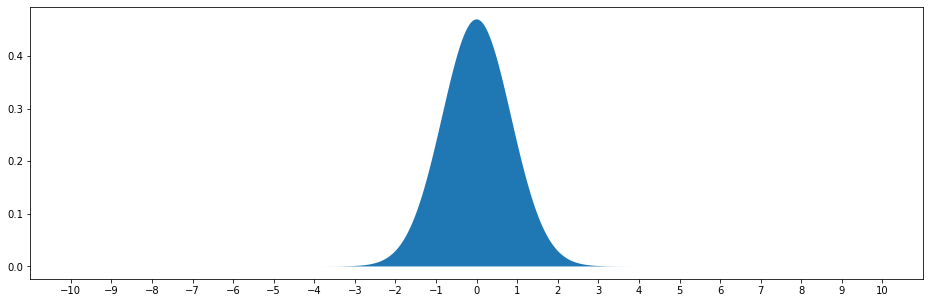

In [4]:
# modulus 
p = 17  # only prime numbers (it has to be a finite field)
print("Prime:", p)

#size parameter
m = 100
print('Count of equations:', m)

# distribution 
## gaussian in this example according to the paper https://cims.nyu.edu/~regev/papers/lwesurvey.pdf (09.11.2021, page 2)
mu = 0
alpha = 0.05
sigma = alpha * p   
print("Mu:", mu, "\t Sigma:", sigma)

## plot the dense function of the distribution
x = np.arange(-10, 10, .001)
y = scipy.stats.norm.pdf(x, loc=mu, scale=sigma)

fig, ax = plt.subplots(figsize=(16, 5))
ax.fill_between(x, y)
ax.set_xticks(range(round(min(x)), round(max(x))+1))
#fig.savefig('gaussian.png')
plt.show()

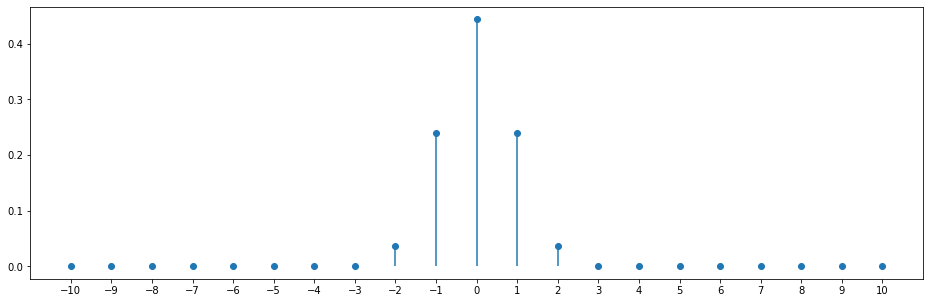

In [5]:
x = np.arange(-10.5, 11.5, 1)
y = scipy.stats.norm.cdf(x, loc=mu, scale=sigma)

z = y[1:] - y[:-1] 

fig, ax = plt.subplots(figsize=(16, 5))
ax.stem(x[:-1]+.5, z, basefmt=" ", use_line_collection=True)
ax.set_xticks(range(round(min(x)), round(max(x))+1))
fig.savefig('smallErrorDiscreteGaussian.png')
plt.show()

## Construct the LWE problem

#### Construct A, b and e 

In [6]:
np.random.seed(42)  # set seed
np.random.randint(0, p)  # discrete uniform distribution (p excluded)
np.random.normal(loc=mu, scale=sigma, size=n)  # gaussian distribution

A = np.random.randint(0, p, size=(m, n))

e = np.rint(np.random.normal(loc=mu, scale=sigma, size=m))  # rounding specified by the IEEE floating point standard IEEE 754 

b = (np.matmul(A, s) + e)%p  # system of linear equations with perturbation

#privateKey = s
#publicKey = (A, b)

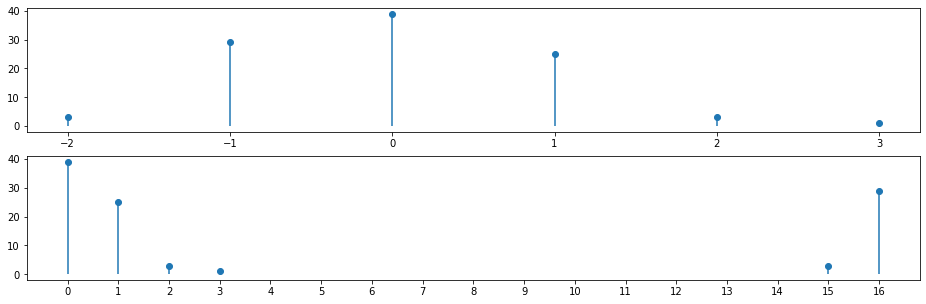

In [7]:
# evaluate error distribution of the concrete LWE instance

fig, ax = plt.subplots(nrows=2, figsize=(16, 5))

unique, counts = np.unique(e, return_counts=True)
ax[0].stem(unique, counts, basefmt=" ", use_line_collection=True)
ax[0].set_xticks(range(round(min(unique)), round(max(unique))+1))

unique, counts = np.unique(e%p, return_counts=True)
ax[1].stem(unique, counts, basefmt=" ", use_line_collection=True)
ax[1].set_xticks(range(round(min(unique)), round(max(unique))+1))

plt.show()

## Solving LWE

### Gaussian Elimination On Subset

In [8]:
# Iterative Algorithm (xgcd)
def iterative_egcd(a, b):
    x,y, u,v = 0,1, 1,0
    while a != 0:
        q,r = b//a,b%a; m,n = x-u*q,y-v*q # use x//y for floor "floor division"
        b,a, x,y, u,v = a,r, u,v, m,n
    return b, x, y

def modinv(a, m):
    g, x, y = iterative_egcd(a, m) 
    if g != 1:
        return None
    else:
        return x % m
    
def solve_linear_congruence(a, b, m):
    """ Describe all solutions to ax = b  (mod m), or raise ValueError. """
    g = math.gcd(a, m)
    if b % g:
        raise ValueError("No solutions")
    a, b, m = a//g, b//g, m//g
    return modinv(a, m) * b % m, m

def print_solutions(a, b, m):
    print(f"Solving the congruence: {a}x = {b}  (mod {m})")
    x, mx = solve_linear_congruence(a, b, m)
    
    print(f"Particular solution: x = {x}")
    print(f"General solution: x = {x}  (mod {mx})")
    
# for debug
print_solutions(272, 256, 1009)

Solving the congruence: 272x = 256  (mod 1009)
Particular solution: x = 179
General solution: x = 179  (mod 1009)


In [9]:
def gaussianEliminationForward(A, b, modulus):
    (m, n) = A.shape
    
    A = np.copy(A[:n][:])
    b = np.copy(b[:n])
    
    
    for j in range(n):  # quadratic matrix
        i = j
        while(i<n-1):
            rowUpper = A[i, :]
            rowUpperLeader = rowUpper[j]
            leftUpper = b[i]
            rowLower = A[i+1, :]
            rowLowerLeader = rowLower[j]
            leftLower = b[i+1]

            if rowLowerLeader==0:
                pass
            elif rowUpperLeader==0 and rowLowerLeader!=0:
                # swap rows
                A[[i, i+1]] = A[[i+1, i]]
                b[[i, i+1]] = b[[i+1, i]]
                i=j-1  # redo column
                
            elif rowUpperLeader!=0 and rowLowerLeader!=0:
                lcm = np.lcm(rowUpperLeader, rowLowerLeader)
                rowLowerNew = (lcm/rowLowerLeader)*rowLower - (lcm/rowUpperLeader)*rowUpper
                leftLowerNew = (lcm/rowLowerLeader)*leftLower - (lcm/rowUpperLeader)*leftUpper
                
                A[i+1, :] = rowLowerNew%modulus
                b[i+1] = leftLowerNew%modulus
                
            i+=1

    return A, b



    
def gaussianEliminationBackward(A, b, modulus):
    (m, n) = A.shape
    x = np.zeros(m)
    
    for i in range(n-1, -1, -1):
        equLeft = A[i, :]
        equLeftCoef = equLeft[i]
        equRight = b[i]
        equRightCoef = equRight - np.dot(x, equLeft)
                    
        solution, mx = solve_linear_congruence(equLeftCoef, equRightCoef, modulus)
        x[i] = solution
    
    return x

# for debug
#print(A[:n])
A_new, b_new = gaussianEliminationForward(A, b, p)
#print(A_new)
#print()
#print(b[:n].astype(int))
#print(b_new.astype(int))
#print()
#print(scipy.linalg.solve(A[:m], b[:m]))
#print(scipy.linalg.solve(A_new, b_new))

In [10]:
try:
    A_new, b_new = gaussianEliminationForward(A, b, p)
    x = gaussianEliminationBackward(A_new%p, b_new%p, p)
    print("Guess:", x.astype(int), "\t", "Right Solution:", s)
except ValueError:  # occurs by linear dependency in the matrix subsetA
    print("linear dependency")

Guess: [16  3 12 15 12] 	 Right Solution: [10 13  9 11  3]


Usually fails because of perturbation

### Gaussian Elimination On A Sample Of Subsets

I solve with gaussian elimination multiple subsets of the given equations and make a majority vote for my guess for s.

In [11]:
random.seed(42)  #set seed
(m, n) = A.shape
subsets = list(itertools.combinations(range(min([200, m])), n)) # set max of 50 to make sure the program do not crash
print('Maximal SampleCount:', len(subsets))

Maximal SampleCount: 75287520


In [12]:
sampleCount = 100000
#sampleCount = len(subsets)

sampleCount = min(sampleCount, len(subsets))
samples = random.sample(subsets, sampleCount)
print('SampleCount:', sampleCount)

SampleCount: 100000


In [13]:
guessCollection = list()
for subset in samples:  
    try:
        subsetA = A[np.array(subset)]
        subsetb = b[np.array(subset)]

        subsetA, subsetb = gaussianEliminationForward(subsetA, subsetb, p)
        x = gaussianEliminationBackward(subsetA%p, subsetb%p, p)
        guessCollection.append(x.astype(int))
        #print("Guess:", x.astype(int), "\t", "Right Solution:", s)
    except ValueError:  # occurs by linear dependency in the matrix subsetA
        #print("linear dependency")
        pass
    
#guessCollection

In [14]:
guessMatrix = np.array(guessCollection).T
guess = list()

for position in range(len(guessMatrix)):
    unique, counts = np.unique(guessMatrix[position], return_counts=True)
    significantList = [scipy.stats.binom_test(count, n=sampleCount, p=1/p, alternative='greater') for count in counts]  # determine significant level
    print(unique, counts) 
    significantArgMin = np.argmin(significantList)
    print("Guess:", significantArgMin)
    print("Min significants:",  significantList[significantArgMin], significantList[significantArgMin]<0.001)
    print()
    indexOfMax = np.argmax(counts)
    guess.append(unique[indexOfMax])
    
print()
print()
if (guess==s%p).all():
    print("Guess:", guess, "\t", "Right Solution:", s%p, "\t", "Solved!")
else:
    print("Guess:", guess, "\t", "Right Solution:", s%p, "\t", "Failed!")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [5622 5577 5416 5647 5612 5444 5621 5385 5572 5467 6214 5428 5523 5353
 5478 5421 5504]
Guess: 10
Min significants: 5.06861370872643e-06 True

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [5459 5612 5580 5394 5432 5558 5402 5494 5416 5475 5410 5591 5502 6144
 5752 5548 5515]
Guess: 13
Min significants: 0.00024351131031610058 True

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [5532 5544 5552 5537 5586 5592 5493 5602 5442 6125 5388 5566 5506 5491
 5458 5402 5468]
Guess: 9
Min significants: 0.0006065855997755373 True

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [5425 5498 5475 5528 5537 5404 5535 5674 5486 5563 5477 6230 5407 5558
 5441 5642 5404]
Guess: 11
Min significants: 1.8682867753627465e-06 True

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [5778 5521 5331 6262 5574 5645 5394 5456 5383 5647 5410 5546 5515 5558
 5163 5582 5519]
Guess: 3
Min significants: 2.236927114807228e-07 True



Guess: [10, 13

Also, I used statistical tests to get a estimation of the confidence of a guess.

### Evaluation

I monitored the count and signification level during the processing.

In [15]:
guessSeries = list()
countSeries = list()
significantsSeries = list()

position = 0
matrixRange = range(1000, len(guessMatrix[position]), 1000)
for i in matrixRange:
    unique, counts = np.unique(guessMatrix[position][:i], return_counts=True)
    countSeries.append(counts)
    significantList = [scipy.stats.binom_test(count, n=sampleCount, p=1/p, alternative='greater') for count in counts]  # determine significant level
    #print(unique, counts) 
    significantArgMin = np.argmin(significantList)
    significantsSeries.append(significantList[significantArgMin])
    #print("Guess:", significantArgMin)
    #print("Min significants:",  significantList[significantArgMin], significantList[significantArgMin]<0.001)
    #print()
    indexOfMax = np.argmax(counts)
    guessSeries.append(unique[indexOfMax])

No handles with labels found to put in legend.


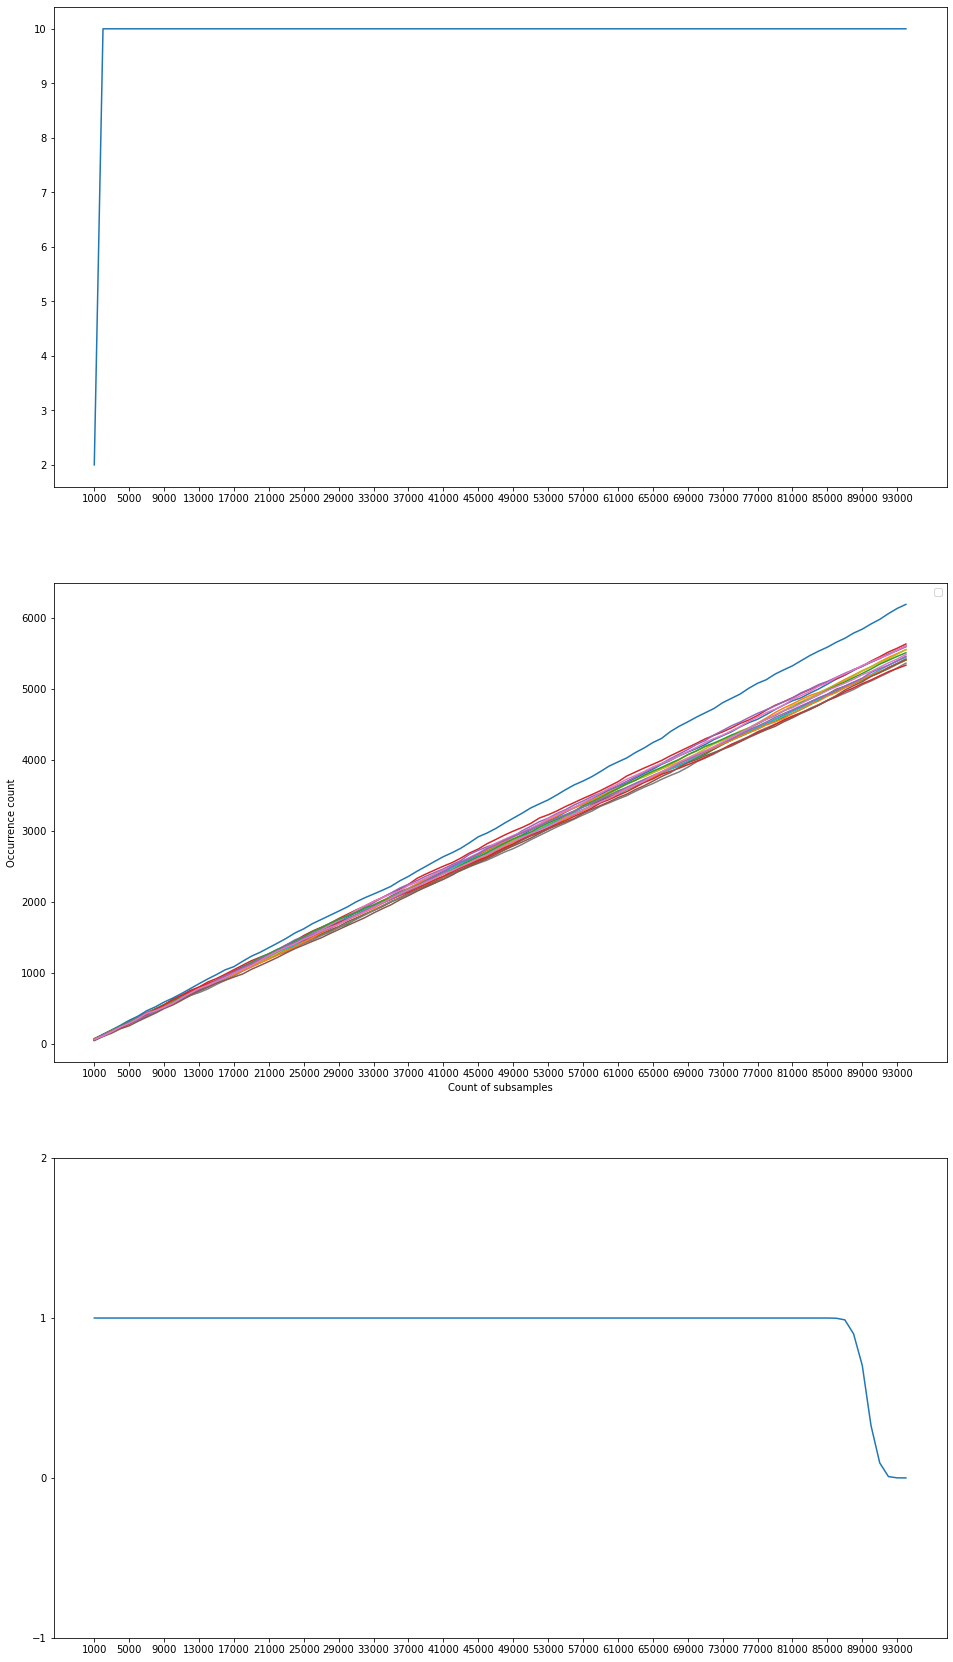

In [16]:
fig, ax = plt.subplots(nrows=3, figsize=(16, 30))
ax[0].plot(matrixRange, guessSeries)
ax[0].set_xticks(matrixRange[::4])

ax[1].plot(matrixRange, countSeries)
ax[1].set_xticks(matrixRange[::4])
ax[1].set_xlabel("Count of subsamples")
ax[1].set_ylabel('Occurrence count')
ax[1].legend()


ax[2].plot(matrixRange, significantsSeries)
ax[2].set_xticks(matrixRange[::4])
ax[2].set_yticks([-1, 0, 1, 2])

#fig.savefig('evaluation.png')
plt.show()

## Conclusion

This method works well for small instances with small errors. But this algorithm suffers under error propagation (see errorPropagation.ipynb). Further work is needed.